# Advanced Regression Techniques

A playground competition hosted by Kaggle to test advanced regression techniques. This notebook serves as a reference for various techniques used to approach and solve regression machine learning problems.

By Wong Tran <br>

In [1]:
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from timeit import default_timer as timer
from scipy.stats import probplot, norm, skew, ttest_ind_from_stats, t, boxcox
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsCV, LassoLarsIC, LassoCV, ElasticNetCV, ElasticNet, Lars
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from art.learning_curve import *
from art.categorical_transformer import *
from art.missing_data import *
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.metrics import mean_squared_error

<br>
<br>

# Contents

- [Initial Data Analysis](#Initial-Data-Analysis)
    - [Read in the data](#Read-in-the-data)
    - [Deal with missing data](#Deal-with-missing-data)
    - [Full missing data transformer](#Full-missing-data-transformer)
    - [Full categorical features transformer](#Full-categorical-features-transformer)
- [Exploratory Data Analysis](#Exploratory-data-analysis)
    - [Target variable](#Target-variable)
    - [Numerical features](#Numerical-features)
    - [Categorical features](#Categorical-features)
    - [Scatterplot Matrix](#Scatterplot-Matrix)
- [First Linear Regression Model](#First-Linear-Regression-Model)
    - [Ordinary Least Squares](#Ordinary-Least-Squares)
    - [Feature selection](#Feature-selection)
        - [Sequential Feature Selection](#Sequential-Feature-Selection)
        - [Cross validated Lasso](#Cross-validated-Lasso)
        - [Random Forest Feature Importance](#Random-Forest-feature-importance)
- [Linear Regression with SFS chosen features](#Linear-Regression-with-SFS-chosen-features)
    - [Remove influential points](#Remove-influential-points)
- [Feature selection with SFS using Log response](#Feature-selection-with-SFS-using-Log-response)
    - [Build model (SFS)](#Build-model-(SFS))
- [Other ML models](#Other-ML-models)
- [Final model](#Final-model)
- [Interpret the model](#Interpret-the-model)
    - [Feature importance](#Feature-importance)
    - [Effect Plots](#Effect-Plots)
    - [Interpreting the effect of feature changes on a Log transformed response](#Interpreting-the-effect-of-feature-changes-on-a-Log-transformed-response)
    - [Prediction-intervals](#Prediction-intervals)

<br>
<br>

# Initial Data Analysis

<br>
<br>

## Read in the data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
all_data = train_df.append(test_df, sort=False)
all_data.drop('SalePrice', axis=1, inplace=True)

In [3]:
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 678.7+ KB


1460/1459 entries (Train/Test)

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data fields

A brief version of what is found in the "data description" file. 

**SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.<br>
**MSSubClass**: The building class<br>
**MSZoning**: The general zoning classification<br>
**LotFrontage**: Linear feet of street connected to property<br>
**LotArea**: Lot size in square feet<br>
**Street**: Type of road access<br>
**Alley**: Type of alley access<br>
**LotShape**: General shape of property<br>
**LandContour**: Flatness of the property<br>
**Utilities**: Type of utilities available<br>
**LotConfig**: Lot configuration<br>
**LandSlope**: Slope of property<br>
**Neighborhood**: Physical locations within Ames city limits<br>
**Condition1**: Proximity to main road or railroad<br>
**Condition2**: Proximity to main road or railroad (if a second is present)<br>
**BldgType**: Type of dwelling<br>
**HouseStyle**: Style of dwelling<br>
**OverallQual**: Overall material and finish quality<br>
**OverallCond**: Overall condition rating<br>
**YearBuilt**: Original construction date<br>
**YearRemodAdd**: Remodel date<br>
**RoofStyle**: Type of roof<br>
**RoofMatl**: Roof material<br>
**Exterior1st**: Exterior covering on house<br>
**Exterior2nd**: Exterior covering on house (if more than one material)<br>
**MasVnrType**: Masonry veneer type<br>
**MasVnrArea**: Masonry veneer area in square feet<br>
**ExterQual**: Exterior material quality<br>
**ExterCond**: Present condition of the material on the exterior<br>
**Foundation**: Type of foundation<br>
**BsmtQual**: Height of the basement<br>
**BsmtCond**: General condition of the basement<br>
**BsmtExposure**: Walkout or garden level basement walls<br>
**BsmtFinType1**: Quality of basement finished area<br>
**BsmtFinSF1**: Type 1 finished square feet<br>
**BsmtFinType2**: Quality of second finished area (if present)<br>
**BsmtFinSF2**: Type 2 finished square feet<br>
**BsmtUnfSF**: Unfinished square feet of basement area<br>
**TotalBsmtSF**: Total square feet of basement area<br>
**Heating**: Type of heating<br>
**HeatingQC**: Heating quality and condition<br>
**CentralAir**: Central air conditioning<br>
**Electrical**: Electrical system<br>
**1stFlrSF**: First Floor square feet<br>
**2ndFlrSF**: Second floor square feet<br>
**LowQualFinSF**: Low quality finished square feet (all floors)<br>
**GrLivArea**: Above grade (ground) living area square feet<br>
**BsmtFullBath**: Basement full bathrooms<br>
**BsmtHalfBath**: Basement half bathrooms<br>
**FullBath**: Full bathrooms above grade<br>
**HalfBath**: Half baths above grade<br>
**Bedroom**: Number of bedrooms above basement level<br>
**Kitchen**: Number of kitchens<br>
**KitchenQual**: Kitchen quality<br>
**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)<br>
**Functional**: Home functionality rating<br>
**Fireplaces**: Number of fireplaces<br>
**FireplaceQu**: Fireplace quality<br>
**GarageType**: Garage location<br>
**GarageYrBlt**: Year garage was built<br>
**GarageFinish**: Interior finish of the garage<br>
**GarageCars**: Size of garage in car capacity<br>
**GarageArea**: Size of garage in square feet<br>
**GarageQual**: Garage quality<br>
**GarageCond**: Garage condition<br>
**PavedDrive**: Paved driveway<br>
**WoodDeckSF**: Wood deck area in square feet<br>
**OpenPorchSF**: Open porch area in square feet<br>
**EnclosedPorch**: Enclosed porch area in square feet<br>
**3SsnPorch**: Three season porch area in square feet<br>
**ScreenPorch**: Screen porch area in square feet<br>
**PoolArea**: Pool area in square feet<br>
**PoolQC**: Pool quality<br>
**Fence**: Fence quality<br>
**MiscFeature**: Miscellaneous feature not covered in other categories<br>
**MiscVal**: $Value of miscellaneous feature<br>
**MoSold**: Month Sold<br>
**YrSold**: Year Sold<br>
**SaleType**: Type of sale<br>
**SaleCondition**: Condition of sale<br>

**Observations**

- The features can be generally split into three categories, those that describe the house's **structure** (e.g. OverallQual, HouseStyle), **space** (e.g.LotArea, TotalBsmtSF) or **location** (e.g. LandSlope, Neighborhood)
- There are plenty of numerical and categorical features included in the dataset. The data is likely **overspecified** with plenty of **extraneous variables**. 
- The success of this regression problem will likely be down to appropriate **feature selection** and **feature engineering**.  

<br>
<br>

## Deal with missing data

In [3]:
feats = list(all_data.columns)
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageFinish,159,5.45


From the data description file, most of the missing data seems to be encoded to indicate the absence of a home feature. These missing data values will be filled in with either a "None" for categorical features, or 0 for numerical features.

For features where it is not clear whether missing data has been pre-encoded, we will assume data is MCAR and perform mode imputation 

<br>
<br>

## Full missing data transformer

Combine all of the missing data handling steps into a single scikit-learn style transformer and import it from a script.

In [4]:
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

In [5]:
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
LotFrontage,486,16.65


"LotFrontage" is a numerical feature where it is not clear from the data description file whether the missing data was encoded.
Since the feature is numrical, we will leave imputation till the end to prevent information leak whilst performing cross validation.

<br>
<br>

## Full categorical features transformer

One-hot-Encode nominal categorical variables and encode ordinal categorical variables with an appropriate ordered mapping.

In [8]:
# List categorical variables
all_data.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 43 columns):
MSZoning         2919 non-null object
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd      2919 non-null object
MasVnrType       2919 non-null object
ExterQual        2919 non-null object
ExterCond        2919 non-null object
Foundation       2919 non-null object
BsmtQual         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     29

In [9]:
ordinal_feats = ["Alley", "Utilities", "LandSlope", "LotShape", "LandContour", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC"]
nominal_feats = ["HouseStyle", "Street", "MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

From the data description file, there appears to be some numerical features that are actually categorical, namely:

- **MSSubCLass** - Identifies the type of dwelling involved in the sale
- **MoSold** - Month Sold
- **YrSold** - Year Sold
- **OverallQual** - Rates the overall material and finish of the house
- **OverallCond** - Rates the overall condition of the house

The first three are nominal categorical variables that have been pre-encoded to numerical values. These numerical values need to be treated as strings and one-hot encoded along with the rest of the nominal categorical features. 

OverallQual and OverallCond are ordinal and are already encoded in numerical format thus no mapping will be required.

We will again combine the categorical feature encoding steps into a single scikit-learn style transformer and import it from a separate script

In [10]:
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 230 entries, Id to YrSold_2010
dtypes: float64(11), int64(44), uint8(175)
memory usage: 1.7 MB


In [12]:
len(cat_transf.all_feature_names)

230

After transforming all of the categorical variables, we have 230 features in total. 

<br>
<br>

# Exploratory data analysis

To perform EDA, we'll look at the training dataset after imputing missing values but without transforming categorical variables.

In [5]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]

In [6]:
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
train_df = missing_imputer.fit_transform(train_df)

<br>
<br>

## Target variable

Check normality of the target variable.

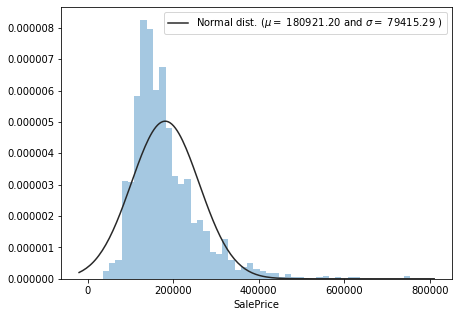

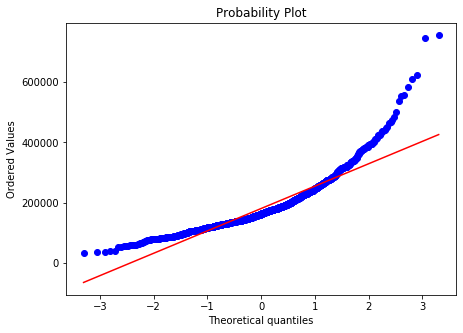

In [16]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['SalePrice'])
sns.distplot(train_labels['SalePrice'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['SalePrice'], plot=plt)
plt.show()

This normal probability plot indicates that the target variable is right skewed. SalePrice is bounded below at 0 and there are many houses which sell for a large amount.

Target variable transformations may have to be used to maintain the assumptions of a regression model but we will investigate this when evaluating our model.

<br>
<br>

## Numerical features

A good way to quickly visualise the linear associations and potential collinearity between all numerical features is a heatmap of correlations

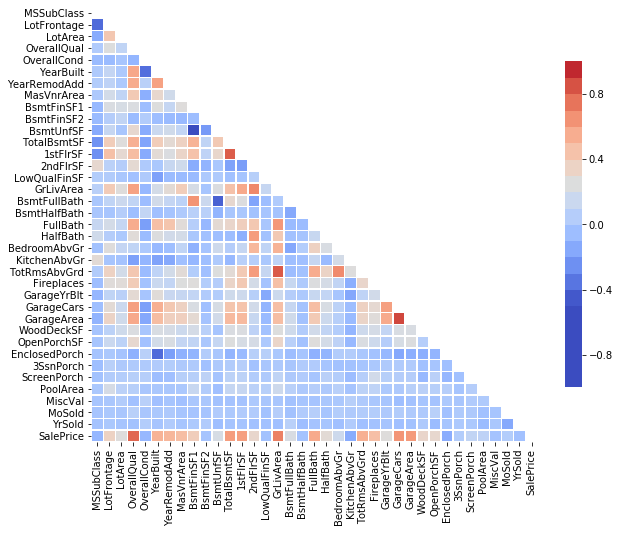

In [17]:
mask = np.zeros_like(train_df.iloc[:,1:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_df.iloc[:,1:].corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(),
                      'shrink':0.75});

**Observations**:

- There appears to be strong collinearity between 'GarageArea' and 'GarageCars' as well as between 'TotRmsAbvGrd' and 'GrLivArea', which makes sense as they are features which are linked and provide almost the same information. Pruning these features may be required to produce a more stable and interpretable model.
- Other features that are correlated include those that provide information about the size of a home as well as features that give information about the homes' capacity, for instance, the link between '1stFlrSF', 2ndFlrSf', 'GarageArea' etc.
- From the bottom rows, there appears to be several numerical features with a strong positive correlation with the target variable, particularly 'OverallQual', 'GrLivArea' as well as several indicators of a home's size.

<br>
<br>

## Categorical features

A feature that stands out from the correlation plot is "OverallQual" which appears to have a strong correlation with the target variable. Since it's an ordinal categorical variable, let's visualize this with a boxplot.

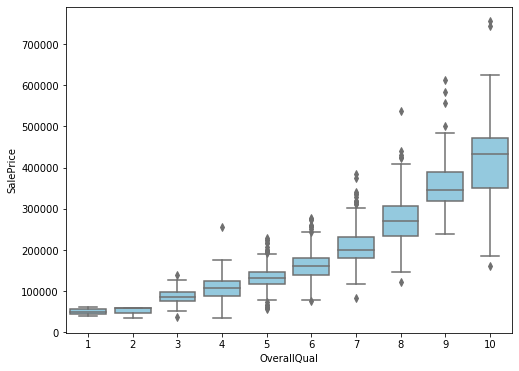

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(train_df['OverallQual'], train_df['SalePrice'], color='skyblue')

A strong positive correlation exists between 'OverallQual' (the overall material and finish of the house) and its sale price which seems pretty intuitive. The relationship doesn't seem to be linear and is heteroscedastic 

<br>
<br>

Let's visualize the relationship between the year a house was built and its Sale Price

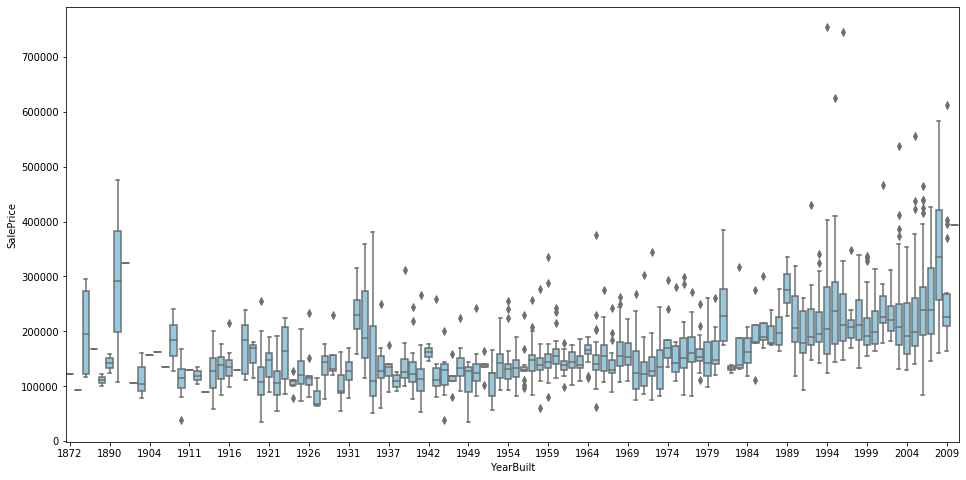

In [19]:
plt.figure(figsize=(16,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df, color='skyblue')
loc, label = plt.xticks()
plt.xticks(loc[::5], label[::5]);

Although there are plenty of exceptions, in general, modern houses (e.g. those built within the last two decades of the dataset) sell for more.
We can easily verify this by checking the median sale price for two time periods.

In [20]:
print("Median sale price of homes built from 1989 onwards: ${}".format(train_df[train_df['YearBuilt']>=1989].SalePrice.median()))
print("Median sale price of homes built before 1989: ${}".format(train_df[train_df['YearBuilt']<1989].SalePrice.median()))

Median sale price of homes built from 1989 onwards: $215600.0
Median sale price of homes built before 1989: $137950.0


**Two-tailed difference of two means t-test**

In [19]:
ttest_ind_from_stats(mean1=train_df[train_df['YearBuilt']>=1989].SalePrice.mean(), 
                     std1=train_df[train_df['YearBuilt']>=1989].SalePrice.std(ddof=1), 
                     nobs1=len(train_df[train_df['YearBuilt']>=1989]), 
                     mean2=train_df[train_df['YearBuilt']<1989].SalePrice.mean(), 
                     std2=train_df[train_df['YearBuilt']<1989].SalePrice.std(ddof=1), 
                     nobs2=len(train_df[train_df['YearBuilt']<1989]), 
                     equal_var=False)

Ttest_indResult(statistic=23.303598658604265, pvalue=1.1541766399276009e-91)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses built before 1989 is statistically different and less than the mean sale price of houses built after 1989

<br>
<br>

Let's see if there is any seasonality in the relationship between the sale month of homes and their sale price 

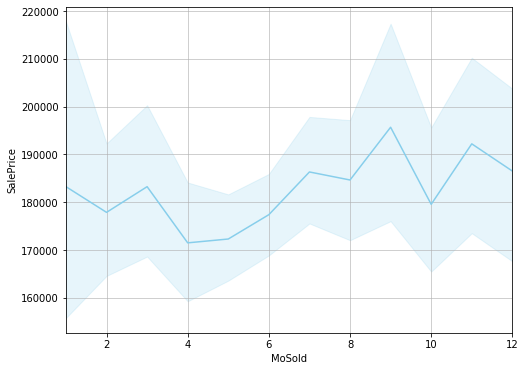

In [21]:
plt.figure(figsize=(8,6))
sns.lineplot(x='MoSold', y='SalePrice', data=train_df, color='skyblue', 
             estimator='mean', ci=95) # 1-sigma
plt.grid(alpha=0.75)
plt.xlim(1,12);

There is large variability in the sale price of homes with respect to the month it was sold, however, the first half of the year (Q1, Q2) seems to have slightly lower home sale prices compared to the second half (Q3, Q4). Let's verify this. 

In [22]:
print("Q1 and Q2 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']<7].SalePrice.median()))
print("Q3 and Q4 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']>=7].SalePrice.median()))

Q1 and Q2 median home sale prices: $158950.0
Q3 and Q4 median home sale prices: $170000.0


**Two-tailed difference of two means t-test**

In [21]:
from scipy.stats import ttest_ind_from_stats, t
ttest_ind_from_stats(mean1=train_df.loc[train_df['MoSold']<7].SalePrice.mean(), 
                     std1=train_df.loc[train_df['MoSold']<7].SalePrice.std(ddof=1), 
                     nobs1=len(train_df.loc[train_df['MoSold']<7]), 
                     mean2=train_df.loc[train_df['MoSold']>=7].SalePrice.mean(), 
                     std2=train_df.loc[train_df['MoSold']>=7].SalePrice.std(ddof=1), 
                     nobs2=len(train_df.loc[train_df['MoSold']>=7]), 
                     equal_var=False)

Ttest_indResult(statistic=-2.47298419419772, pvalue=0.01352266431182276)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses sold during the first half of the year is statistically different and less than the mean sale price of houses sold during the second half of the year.

<br>
<br>

## Scatterplot Matrix

Since there are too many numerical variables to visualize all at once, let's make a scatterplot matrix (pairplot) of numerical features that have a correlation greater than 0.5 between them and the target variable.

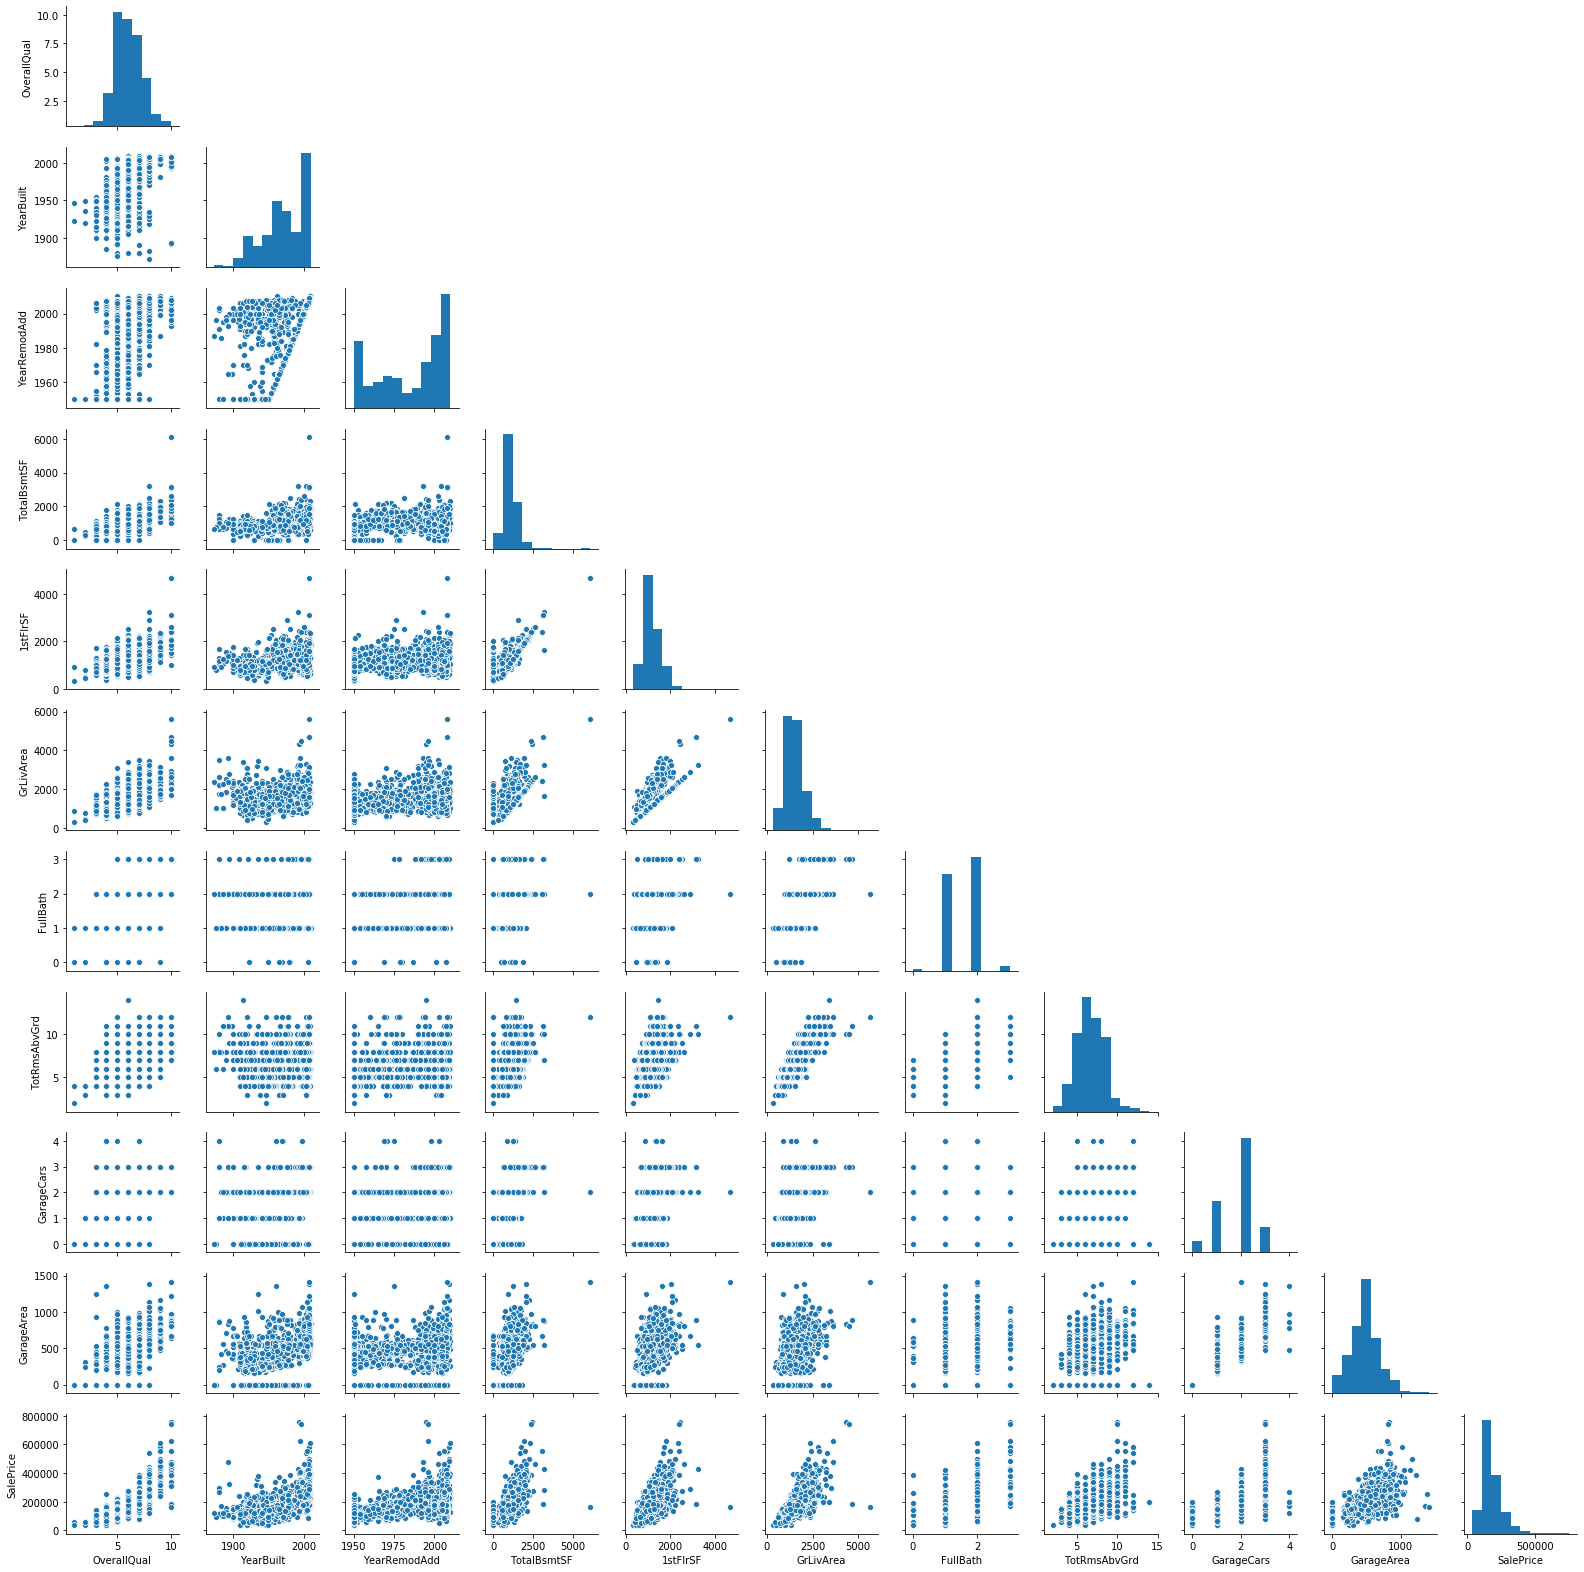

In [23]:
corr_saleprice = np.abs(train_df.corr()['SalePrice'])
feats05greater = corr_saleprice[corr_saleprice>0.5].index

g = sns.pairplot(train_df.loc[:,feats05greater], height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
del(corr_saleprice)

The best numerical predictors of sale price are features that tell us information about the home's size, the number of rooms they have as well as the year they were built/remodelled. 

<br>
<br>

# First Linear Regression Model

In [2]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

# Create LotFrontage imputer
lotfrontage_imputer = MissingDataImputer(impute_lotfrontage=True)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

<br>
<br>

## Ordinary Least Squares

In [3]:
train_df = SimpleImputer(strategy='median').fit_transform(train_df)
X_train_with_bias = sm.add_constant(train_df)  # Add feature of ones 
lin_regr = sm.OLS(train_labels['SalePrice'].values, X_train_with_bias).fit()

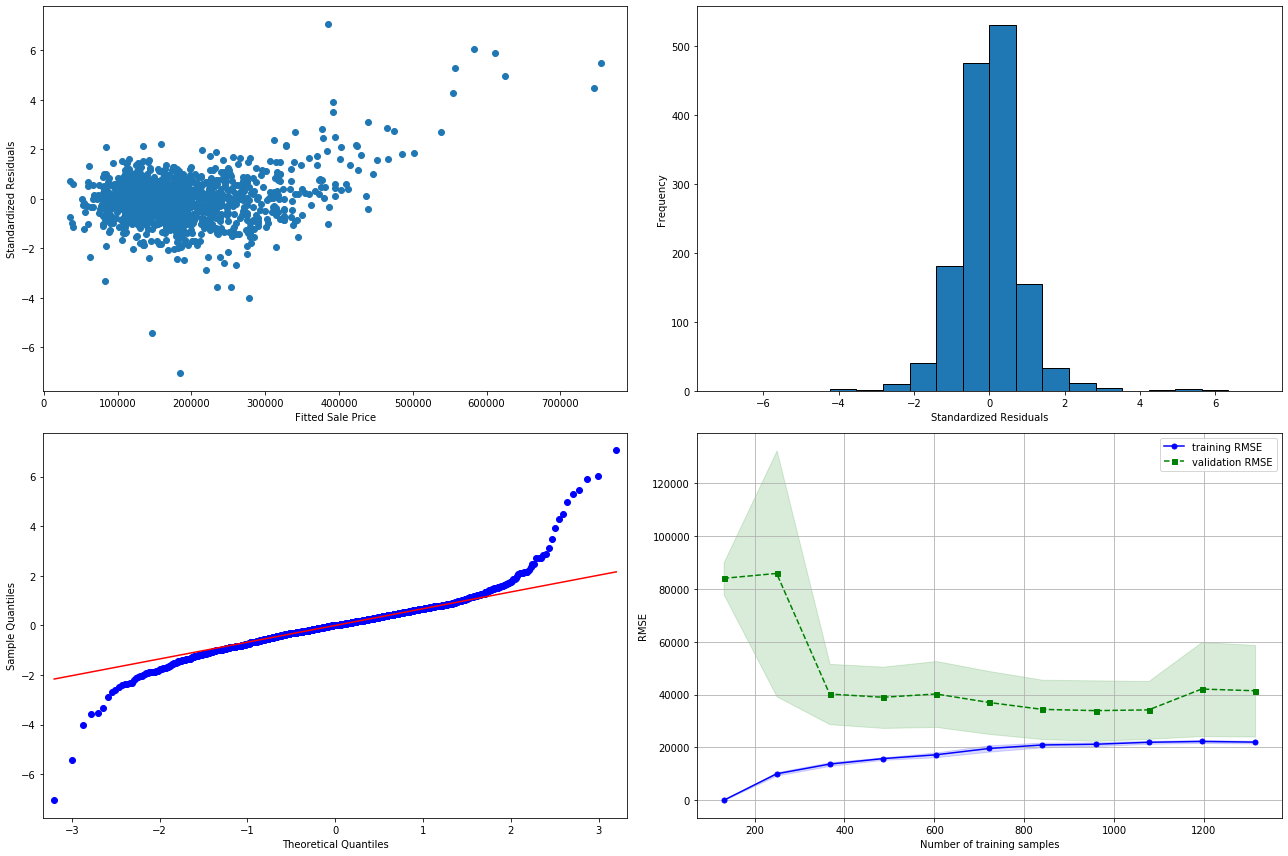

In [6]:
########### Plots ###########
fig=plt.figure(figsize=(18,12))

ax1 = plt.subplot(221)
ax1.scatter(train_labels['SalePrice'].values, lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(222)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(223)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(224)
lin_regr_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('lin_regr', LinearRegression())])
lin_regr_pipe.fit(train_df, train_labels['SalePrice'])

lc_params = compute_learning_curve(estimator=lin_regr_pipe, 
                                X=train_df, 
                                y=train_labels['SalePrice'].values,
                                cv=10)
plot_learning_curve(ax4, lc_params)
plt.tight_layout()

**Observations**

- According to the $R^2$ there is a potentially strong linear association between the features and the response, ~92.0% of the variation in SalePrice is explained by the features.
- The residual plot shows a departure from linearity for high values of "SalePrice", indicating that a non-linear fit would be better. As a result of the non-linearity it is difficult to tell if the model is affected by heteroscedasticity
- The normal probability plot for the residuals indicate departure from normality in the high and low quartiles. This is indicative of a heavy-tailed distribution as can be seen in the histogram of residuals
- The learning curve shows that the model is performing better on the training set compared to the validation set which is an indication of overfitting. There is a bump in validation RMSE at around 1100 training samples, as a result it is not clear whether more data would improve the model.

In [6]:
vif_dict = {}
for idx, feat in enumerate(train_df.columns):
    vif_dict[feat] = variance_inflation_factor(X_train_with_bias, idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
vif_series.sort_values(ascending=False).head(30)

Exterior2nd_CBlock             inf
GrLivArea                      inf
LowQualFinSF                   inf
2ndFlrSF                       inf
BldgType_Duplex                inf
1stFlrSF                       inf
TotalBsmtSF                    inf
Exterior1st_CBlock             inf
BsmtUnfSF                      inf
BsmtFinSF2                     inf
BsmtFinSF1                     inf
MSSubClass_90                  inf
GarageYrBlt            2148.049979
GarageType_None        1994.406296
MiscFeature_None        967.664861
MiscFeature_Shed        807.269052
RoofStyle_Gable         159.439915
RoofStyle_Hip           147.939037
MSSubClass_20           139.645322
MSSubClass_60           121.934431
Exterior1st_VinylSd     113.648035
Exterior2nd_VinylSd     104.144515
GarageType_Attchd        81.433388
Exterior1st_MetalSd      75.306730
MSSubClass_50            70.899255
Exterior2nd_MetalSd      69.369170
GarageType_Detchd        65.309908
Exterior1st_HdBoard      58.618184
HouseStyle_1Story   

In accordance with our initial impressions of the data, there are many features in the dataset most of which have a high VIF (>15) indicating a large number of collinear features that provide the same information about the houses being sold. To mitigate overfitting we first perform variable selection to reduce the number of features before attempting any non-linear regression methods or introducing non-linear and interaction features in order to tackle the non-linearity.

<br>
<br>

## Feature selection

<br>
<br>

### Sequential Feature Selection

In [ ]:
feat_names = list(train_df.columns)
sfs_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('lin_regr', LinearRegression())])

sfs = SFS(sfs_pipe, 
          k_features='parsimonious', 
          forward=True, 
          floating=True, 
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=4
         )

sfs = sfs.fit(train_df.values, train_labels['SalePrice'], custom_feature_names=feat_names)

In [56]:
print("Parsimonious SFS:\n")
print("{} features chosen by SFS\n".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

Parsimonious SFS:

29 features chosen by SFS

Selected features: ('LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60')

Best score: 30338.49583463479


In [10]:
sfs_scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_scores.to_csv("data/sfs_df.csv", index=False)  # Save the SFS results
sfs_scores['RMSE'] = (-sfs_scores['avg_score'])**0.5

In [42]:
sfs_scores.sort_values('avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
84,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17026794, -889771180.8025004, -826...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
85,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.170296, -889771180.8026042, -82671...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
86,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17023355, -890241337.8664689, -826...",-8.61766e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48159e+08,3.48683e+08,1.74341e+08,29355.9
87,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86457294, -888579457.4638133, -827...",-8.61799e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47118e+08,3.47873e+08,1.73937e+08,29356.4
88,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86455476, -889121987.4611645, -826...",-8.61836e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47075e+08,3.47839e+08,1.7392e+08,29357


Chosen parsimonious model

In [41]:
sfs_scores[sfs_scores['avg_score']==sfs.k_score_]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
29,"(1, 2, 3, 14, 22, 24, 26, 30, 38, 42, 43, 46, ...","[-498090438.6093986, -978074034.8905374, -9275...",-9.20424e+08,"(LotArea, OverallQual, OverallCond, GrLivArea,...",4.00323e+08,3.11465e+08,1.55733e+08,30338.5


<br>
<br>

### Cross validated Lasso

The same optimal regularization parameter $\alpha$ can be obtained much more efficiently using `LassoCV` or `LassoLarsCV` which is done by directly modifying the optimization method instead of using a grid search wrapper. We still use the wrapper method below for illustrative purposes in order to obtain a good visualization of the optimization path. 

In [138]:
lasso_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(max_iter=10000))])
lasso_gs = GridSearchCV(lasso_pipe,
                        {'lasso__alpha':np.logspace(2,4, 201)},
                        'neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=10,
                       )
best_lasso = lasso_gs.fit(train_df.values, train_labels['SalePrice'])
lasso_cv_scores = pd.DataFrame(best_lasso.cv_results_)

Best param: {'lasso__alpha': 831.7637711026708}
Best MSE: -1093099432.434754
Best RMSE: 33062.05426822045


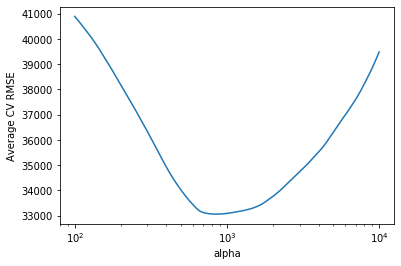

In [139]:
print("Best param:",best_lasso.best_params_)
print("Best MSE:",best_lasso.best_score_)
print("Best RMSE:",np.sqrt(-best_lasso.best_score_))

alpha = lasso_cv_scores.param_lasso__alpha.values
cv_score = lasso_cv_scores.mean_test_score.values

plt.yscale("linear")
plt.xscale("log")
plt.plot(alpha, np.sqrt(-cv_score))
plt.xlabel("alpha")
plt.ylabel("Average CV RMSE");

In [140]:
feat_names = list(train_df.columns)
lasso_coefs = sorted(list(zip(feat_names, best_lasso.best_estimator_.named_steps['lasso'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print("{} features chosen by Lasso".format(np.sum(best_lasso.best_estimator_.named_steps['lasso'].coef_!=0)))
print([feat[0] for feat in lasso_coefs if feat[1]!=0])

81 features chosen by Lasso
['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'FullBath', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCon

**`LassoCV` gives approximately the same optimal $\alpha$ and chooses the same features**

In [147]:
lassocv_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', StandardScaler()),
                         ('Lasso', LassoCV(max_iter=10000, normalize=False, cv=10, n_jobs=4))])
lassocv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassocv_pipe.named_steps['Lasso'].alpha_

830.3910103604513

In [148]:
feat_names = list(train_df.columns)
lassocv_coefs = sorted(list(zip(feat_names, lassocv_pipe.named_steps['Lasso'].coef_)), 
                       key=lambda x: x[1], 
                       reverse=True)
print([feat[0] for feat in lassocv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'FullBath', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'Condition1_

In [149]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassocv_coefs if feat[1]!=0])

set()

**`LassoLarsCV` gives approximately the same optimal $\alpha$ and chooses approximately the same features**

In [150]:
lassolarscv_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scale', StandardScaler()),
                             ('LassoLars', LassoLarsCV(max_iter=10000, normalize=False, cv=10, n_jobs=4))])
lassolarscv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassolarscv_pipe.named_steps['LassoLars'].alpha_

851.0084094948371

In [151]:
feat_names = list(train_df.columns)
lassolarscv_coefs = sorted(list(zip(feat_names, lassolarscv_pipe.named_steps['LassoLars'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'MSSubClass_20', 'Neighborhood_Crawfor', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'FullBath', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HeatingQC', 'HalfBath', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'MoSold_7', 'Utilities', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'LotConfig_FR3', 'Conditi

In [152]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

{'3SsnPorch'}

<br>
<br>

### Random Forest feature importance

With the help of the `RFECV` wrapper, we can iteratively prune features using the Random Forest `feature_importances_` attribute. Important features are those that when split on results in a large impurity decrease when averaged over all of the decision trees in the forest.

In [ ]:
train_df_copy = SimpleImputer(strategy='median').fit_transform(train_df)
rand_for = RandomForestRegressor(n_estimators=1000, n_jobs=4, max_features='sqrt')
selector = RFECV(rand_for, step=1, cv=5, n_jobs=2, scoring='neg_mean_squared_error', verbose=1)
selector = selector.fit(train_df_copy, train_labels['SalePrice'])

In [34]:
feat_names = np.array(train_df.columns)
print("{} features selected\n".format(selector.n_features_))
print(list(feat_names[selector.support_]),"\n")
print("Random Forest best RMSE: {}".format(np.sqrt(-selector.grid_scores_[37])))

38 features selected

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'HouseStyle_2Story', 'Neighborhood_NoRidge', 'Foundation_PConc', 'GarageType_Attchd', 'MSSubClass_60'] 

Random Forest best RMSE: 28782.81928525163


<br>
<br>

**Other feature selection techniques:**

- **Lasso Lars IC** - Perform the Lasso feature selection using an Information Criterion rather than directly using the evaluation metric (MSE). This should result in a different set of features 
    - Gives errors when tried
- **RFECV using `coef_`** - Recursive feature elimination using the magnitude of regression coefficient values as an indicator of feature importance (unimportant features are pruned first)
    - Relies on using the magnitude of coefficients in an additive model as an indicator of feature importance which is sensitive to the scale of features without normalization. We avoid normalization to retain model interpretability
- **PLS & PCR** - Selects linear combination of features that either retain a certain level of feature variance (PCA) or finds directions in the linear subspace that are most correlated with the response (PCR).
    - These methods are not used in an attempt to retain model interpretability as producing linear combinations of features results in a feature set that is not immediately interpretable

<br>
<br>

# Linear Regression with SFS chosen features

In [2]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# From above
sfs_feats = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60']
train_df_sfs = train_df[sfs_feats]

In [3]:
lin_regr = sm.OLS(train_labels['SalePrice'].values,
                  sm.add_constant(train_df_sfs.values)).fit()
lin_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     313.0
Date:                Sun, 11 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:17:14   Log-Likelihood:                -17088.
No. Observations:                1460   AIC:                         3.424e+04
Df Residuals:                    1430   BIC:                         3.439e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.381e+05   8067.166    -17.117      0.000   -1.54e+05   -1.22e+05
x1             0.3226      0.087      3.692      0.000       0.151       0.494
x2          1.058e+04   1044.922     10.126      0.000    8531.338    1.26e+04
x3          3671.2034    764.496      4.802      0.000    2171.550    5170.857
x4            51.5898      2.423     21.292      0.000      46.837      56.343
x5          4981.0443   1484.599      3.355      0.001    2068.818    7893.271
x6          1.368e+04   1707.346      8.013      0.000    1.03e+04     1.7e+04
x7            20.9654      6.830      3.070      0.002       7.568      34.363
x8            38.1636     14.421      2.646      0.008       9.876      66.451
x9          9585.5801   2310.693      4.148      0.000    5052.869    1.41e+04
x10         7163.8896    861.953      8.311      0.000    5473.062    8854.717
x11         2923.1347    415.522      7.035      0.000    2108.038    3738.232
x12         9093.1094   1835.662      4.954      0.000    5492.231    1.27e+04
x13        -4503.0778   1231.551     -3.656      0.000   -6918.918   -2087.237
x14        -1.173e+04   2981.562     -3.935      0.000   -1.76e+04   -5885.040
x15         1.293e+04   3277.989      3.944      0.000    6499.835    1.94e+04
x16         1.687e+04   4183.142      4.032      0.000    8659.423    2.51e+04
x17         2.888e+04   4572.087      6.316      0.000    1.99e+04    3.78e+04
x18         4.992e+04   5240.464      9.527      0.000    3.96e+04    6.02e+04
x19         5.131e+04   4188.374     12.251      0.000    4.31e+04    5.95e+04
x20         1.928e+04   3792.384      5.085      0.000    1.18e+04    2.67e+04
x21          5.64e+04   6381.542      8.838      0.000    4.39e+04    6.89e+04
x22         1.141e+04   2354.916      4.846      0.000    6793.162     1.6e+04
x23         6320.8659   2098.499      3.012      0.003    2204.400    1.04e+04
x24         8.153e+04   1.25e+04      6.512      0.000     5.7e+04    1.06e+05
x25         1.582e+04   4410.745      3.587      0.000    7171.305    2.45e+04
x26         1.692e+04   4361.220      3.879      0.000    8361.000    2.55e+04
x27         1.868e+04   3290.901      5.675      0.000    1.22e+04    2.51e+04
x28         1.905e+04   2040.827      9.333      0.000     1.5e+04    2.31e+04
x29          2.27e+04   3322.486      6.831      0.000    1.62e+04    2.92e+04
==============================================================================
Omnibus:                      545.760   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61549.588
Skew:                          -0.718   Prob(JB):                         0.00
Kurtosis:                      34.776   Cond. No.                     2.36e+05
==============================================================================

W

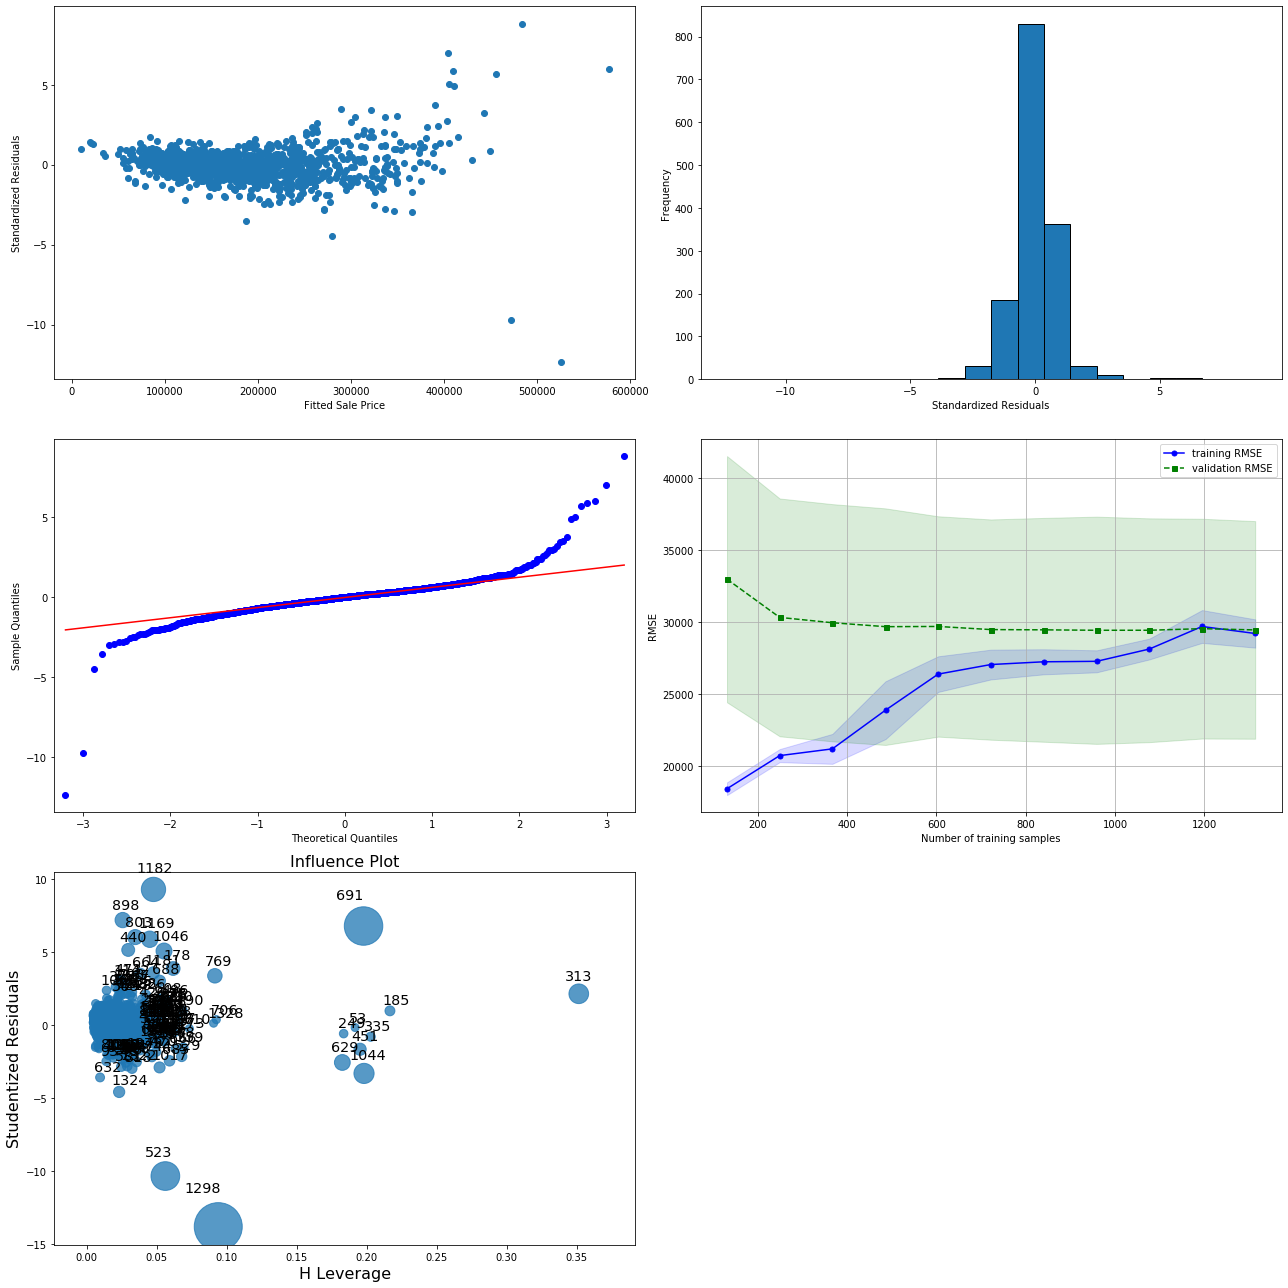

In [9]:
########### Plots ###########
fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_sfs.values, train_labels['SalePrice'].values)

lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_sfs.values, 
                                   y=train_labels['SalePrice'].values,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

ax5 = plt.subplot(325)
fig = sm.graphics.influence_plot(lin_regr, ax=ax5, criterion="cooks")
plt.tight_layout()

**Observations**

- With the SFS reduced feature set, the $R^2$ value has reduced slightly to 0.864. However because of the non-linearity present, this result doesn't necessarily indicate a worse fit as a linear model is still inappropriate for the data.
- All the features have a p-value < 0.05 which means they statistically significantly differ from 0. They are all linearly associated with the response after accounting for all other features in the model
- According to the normal plot and the histogram, the residuals are still non-normal and heavy-tailed
- The residual plot shows a slight upward pattern which is indicative that a linear fit is inappropriate for this regerssion problem
- The variance of the residuals increases with the size of the prediction i.e. the residuals are heteroscedastic
- According to the the learning curve:
    - Although it looks like there is more variation in the validation RMSE, this is actually due to the scale of the plot. The standard deviation for this curve at 1000 training samples is $\approx \pm 7500$ compared to $\approx \pm 15000$ using the whole feature set
    - The overfitting problem appears to have been mitigated as can be seen by the convergence of the training and validation RMSE curves
    - The learning curve is now indicative of a high bias problem since the training and validation error has converged to an RMSE value that's not particularly low (The Random Forest used in feature selection was able to achieve ~28000 CV RMSE)
- The bias can also be seen in the residual plot by the non-linearity present. 
- From the [influence plot](https://www.statsmodels.org/stable/examples/notebooks/generated/regression_plots.html) and the residual plot:
    - Point 1298, 523 and 1324 seems to not be following the upward trend in the residual plot and are also highly influential points as measured by their Cook's distance since they have high leverage and are outliers (have large absolute residuals)

<br>
<br>

## Remove influential points

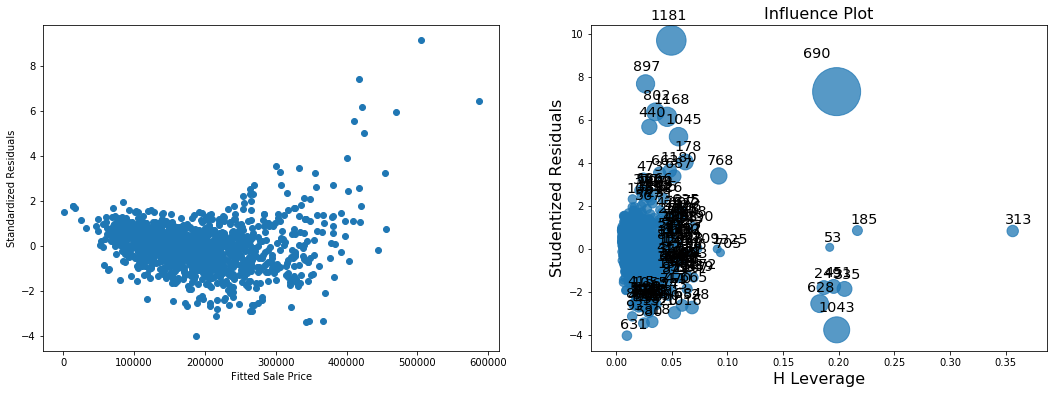

In [10]:
influential_points = [1298, 523, 1324]
lin_regr_drop = sm.OLS(train_labels['SalePrice'].drop(influential_points).values,
                  sm.add_constant(train_df_sfs.drop(influential_points).values)).fit()

fig=plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax1.scatter(lin_regr_drop.predict(), lin_regr_drop.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(122)
fig = sm.graphics.influence_plot(lin_regr_drop, ax=ax2, criterion="cooks")

After removing the influential plots pulling the fit down, we have a clean upward trend that the linear fit from our model can't capture. It's time to tackle the non-linearity in the data!

<br>
<br>

# Feature selection with SFS using Log response

Since we are ultimately fitting an OLSR model to the data after feature selection, a feature selection algorithm that uses an OLSR as the base estimator may result in better performance than an L1 regularization based feature selector (then fitting an OLSR on top of that).

Try the greedy selection variant of SFS (non-floating) first since the floating variant is inefficient and may possibly overfit the training set.

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

influential_points = [1298, 523, 30, 632]
train_df.drop(influential_points, inplace=True)
train_labels.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df.select_dtypes(include='uint8').columns)
num_feats = list(train_df.select_dtypes(exclude='uint8').columns)
train_df_scaled = scaler.fit_transform(train_df[num_feats])
train_df = np.column_stack((train_df_scaled, train_df[cat_feats].values))
train_df = pd.DataFrame(train_df, columns = num_feats+cat_feats)
del(train_df_scaled)

feat_names = list(train_df.columns)
sfs_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('lin_regr', LinearRegression())])

sfs = SFS(sfs_pipe, 
          k_features='parsimonious', 
          forward=True, 
          floating=False, # Greedy selection
          verbose=1,
          scoring='neg_mean_squared_error',
          cv=10,
          n_jobs=5
         )

sfs = sfs.fit(train_df.values, np.log(train_labels['SalePrice'].values), custom_feature_names=feat_names)

In [4]:
print("Parsimonious SFS:\n")
print("{} features chosen by SFS\n".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

Parsimonious SFS:

49 features chosen by SFS

Selected features: ('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5')

Best score: 0.10430283505677086


In [8]:
sfs_scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_scores.to_csv("data/sfs_df_log_response_non_floating.csv", index=False)  # Save the SFS results
sfs_scores['RMSE'] = (-sfs_scores['avg_score'])**0.5

In [9]:
sfs_scores.sort_values('avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
78,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010032162999424363, -0.008882503536288259,...",-0.0106628,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00149485,0.00201269,0.000670897,0.103261
80,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010205674437046881, -0.00873888535516394, ...",-0.0106812,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00151634,0.00204162,0.00068054,0.10335
72,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.009964993384053121, -0.008825820568827913,...",-0.010691,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00172951,0.00232863,0.000776211,0.103397
67,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010126939092546338, -0.009001822087242043,...",-0.0106916,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00169934,0.00228802,0.000762673,0.1034
75,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 17, 18...","[-0.010099716290393527, -0.008586819777907559,...",-0.0106945,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00165299,0.0022256,0.000741868,0.103414


Chosen parsimonious model

In [7]:
sfs_scores[sfs_scores['avg_score']==sfs.k_score_]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
49,"(0, 1, 2, 3, 4, 5, 7, 10, 14, 15, 17, 18, 20, ...","[-0.010429587853682854, -0.008918473067264414,...",-0.0108791,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.00168611,0.00227021,0.000756736,0.104303


<br>
<br>

**Parsimonious score features**

In [21]:
print("Log RMSE: {}".format(np.sqrt(-sfs.k_score_)))
print(sfs.k_feature_names_)

Log RMSE: 0.10430283505677086
('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5')


**Best score features**

In [22]:
print("Log RMSE: {}".format(np.sqrt(-sfs_scores.sort_values('avg_score', ascending=False).iloc[0,:].avg_score)))
print(sfs_scores.sort_values('avg_score', ascending=False).iloc[0,:].feature_names)

Log RMSE: 0.10326087721838098
('LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Alley', 'LandSlope', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'LotConfig_FR3', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_TwnhsE', 'RoofStyle_Gable', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsphShn', 'Exte

<br>
<br>

## Build model (SFS)

We now use the SFS features from above to rebuild an OLSR model. <br>
The same iterative procedure from the lasso model above was followed to improve the model with the addition of:
- Checking for skewed features and using an appropriate transformation

18160.718078601494


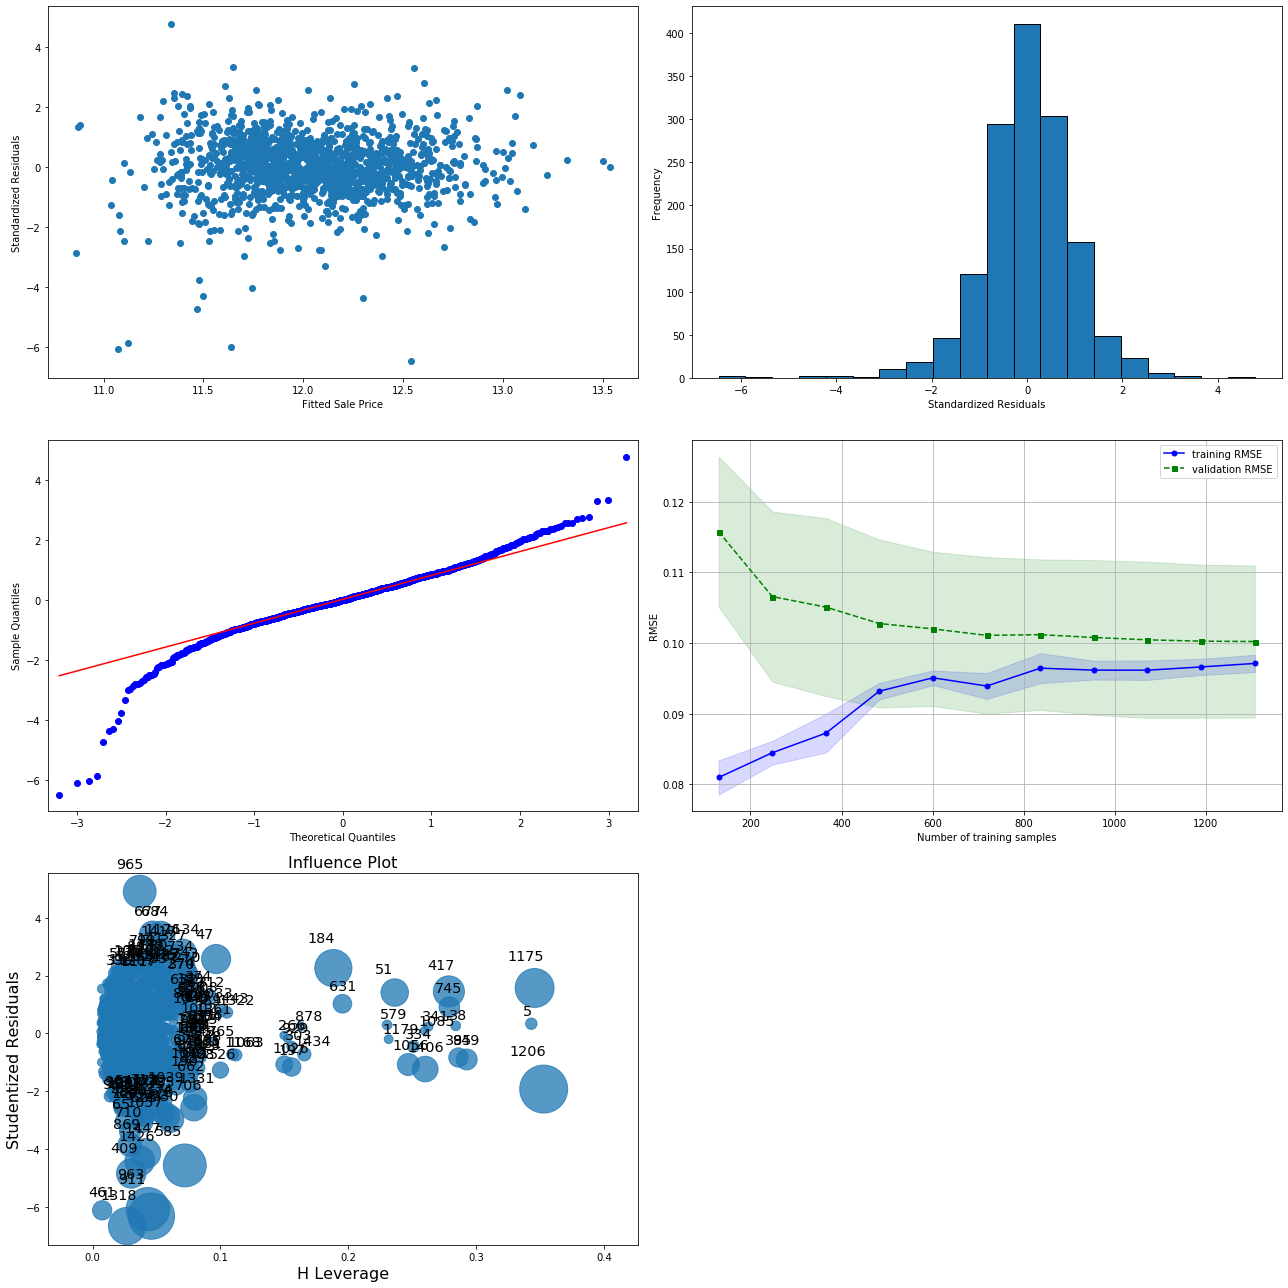

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs.drop(columns='LotArea', inplace=True)
test_df_sfs.drop(columns='LotArea', inplace=True)

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

X_train = train_df_sfs.values
X_test = test_df_sfs.values
y_train = np.log(train_label['SalePrice'].values)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lin_regr = sm.OLS(y_train, X_train).fit()
lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_sfs.values, y_train)

print(np.sqrt(mean_squared_error(train_label['SalePrice'].values, np.exp(lin_regr.predict()))))

########### Plots ###########

fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_sfs.values, 
                                   y=y_train,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

ax5 = plt.subplot(325)
fig = sm.graphics.influence_plot(lin_regr, ax=ax5, criterion="cooks")
plt.tight_layout()

In [ ]:
# To retrieve the index number of highly influential points
a = OLSInfluence(lin_regr).summary_frame()
a.student_resid.sort_values().head(30)

<br>
<br>

**Feature importance**

In [3]:
coef_dict = {}
coef_dict['intercept'] = lin_regr.params[0]

for idx, coef in enumerate(lin_regr.params[1:]):
    coef_dict[list(train_df_sfs.columns)[idx]] = coef
coef_series = pd.Series(coef_dict)
del(coef_dict)
np.abs(coef_series).sort_values(ascending=False).head(30)

<br>
<br>

**Plot potential interactions**

In [ ]:
train_df_sfs_copy = train_df_sfs.copy()
train_df_sfs_copy['SalePrice'] = np.log(train_label['SalePrice'].values)
sns.pairplot(train_df_sfs_copy[num_feats[:13]+['SaleType_New','SalePrice']], 
             vars=num_feats[:13]+['SalePrice'],
             hue='SaleType_New'
            )
sns.pairplot(train_df_sfs_copy[num_feats[13:]+['SaleType_New','SalePrice']], 
             vars=num_feats[13:]+['SalePrice'],
             hue='SaleType_New'
            )

<br>
<br>

**Check VIFs**

In [ ]:
vif_dict = {}
for idx, feat in enumerate(train_df_sfs.columns):
    vif_dict[feat] = variance_inflation_factor(sm.add_constant(train_df_sfs.values), idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)
vif_series.sort_values(ascending=False)

<br>
<br>

**Skewed features**

In [7]:
skew_dict = {}
for col in train_df_sfs.columns:
    skew_dict[col] = skew(train_df_sfs[col].values)#
skew_series = pd.Series(skew_dict)
del(skew_dict)
skew_series.sort_values()

<br>
<br>

**Make submission**

In [3]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(lin_regr.predict(X_test))
submission_df.to_csv("submissions/{}{}{}_attempt7_OLSR_OLSRfeats_minFE.csv".format(today.year,today.month,today.day), index=False)

**Submission history**

**0.12196** Initial test score. Greedy SFS parsimonious features (Drop influential points: [1298, 523, 30, 632])

**0.12372** Greedy SFS Best features. (Drop influential points: [1298, 523, 30, 632])

**0.12221** Greedy SFS Best features. (Drop influential points: [1298, 523, 30, 632]). Dropped binary features that are mostly turned on (1 for all observations) or turned off: ['Foundation_Wood', 'Heating_Wall', 'HouseStyle_2.5Fin', 'SaleCondition_AdjLand', 'Street_Pave']

**0.12117** Same as above. Add 'log_LotArea' instead of boxcox_LotArea. Add 'GrLivArea_SaleType_New'

**0.12104** Same as above, drop more influential points: [1298, 523, 30, 632, 812, 495]

**0.12164** Same as above, drop even more influential points: [1298, 523, 30, 632, 812, 495, 916, 1324, 462, 968]

**0.12093** Greedy SFS. Just add log_LotArea, drop "GarageYrBlt" and only drop the following influential features [1298, 523, 30, 632, 812, 495]

**0.12090** Greedy SFS. Add log_LotArea, drop "GarageYrBlt" and only drop the following influential features [1298, 523, 30, 632, 812, 495]. Drop LotArea (Since the transformed log_LotArea exists in the feature set and results in multicollinearity when included with the non-transformed feature)

<br>
<br>

## Other ML models

<br>
<br>

**GBRT**

In [3]:
gbr = GradientBoostingRegressor(learning_rate=0.05)
gbr_gs = GridSearchCV(gbr, {'n_estimators':[300,400,500,600,700,800,900]}, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=10)
best_gbr = gbr_gs.fit(train_df_sfs.values, y_train)

{'n_estimators': 700}


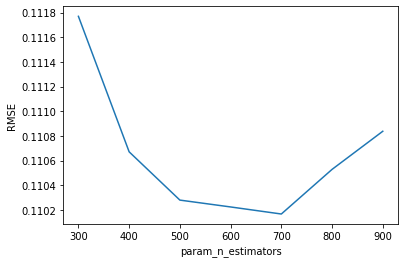

In [4]:
gbr_gs_results = pd.DataFrame(best_gbr.cv_results_)
gbr_gs_results['RMSE'] = np.sqrt(-gbr_gs_results['mean_test_score'])
print(best_gbr.best_params_)
sns.lineplot(x='param_n_estimators', y='RMSE', data=gbr_gs_results);

In [5]:
gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=550)
gbr.fit(train_df_sfs.values, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=550,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(gbr.predict(test_df_sfs.values))
submission_df.to_csv("submissions/{}{}{}_attempt8_GBR_OLSRfeats_FE_drop.csv".format(today.year,today.month,today.day), index=False)

**0.12704**

<br>
<br>

**Random Forest**

In [3]:
rand_for = RandomForestRegressor(n_estimators=2000, max_features='sqrt')
rand_for.fit(train_df_sfs.values, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [4]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(rand_for.predict(test_df_sfs.values))
submission_df.to_csv("submissions/{}{}{}_attempt9_RF_OLSRfeats_FE_drop_more.csv".format(today.year,today.month,today.day), index=False)

**0.14460**

<br>
<br>

**GLM**

In [76]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs['GrLivArea_SaleType_New'] = train_df_sfs['GrLivArea'] * train_df_sfs['SaleType_New']
test_df_sfs['GrLivArea_SaleType_New'] = test_df_sfs['GrLivArea'] * test_df_sfs['SaleType_New']

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

X_train = train_df_sfs.values
X_test = test_df_sfs.values
y_train = train_label['SalePrice'].values
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

glm = sm.GLM(y_train, X_train, family=sm.families.Gaussian(sm.families.links.log)).fit()

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning:

Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



Text(0.5, 1.0, 'GLM Residuals')

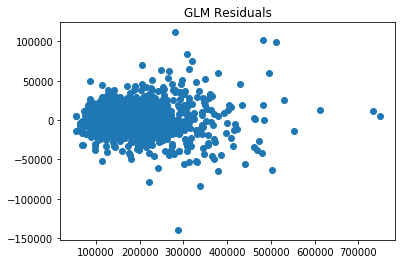

In [3]:
ax1 = plt.subplot(111)
ax1.scatter(glm.predict(), y_train-glm.predict())
ax1.set_title("GLM Residuals")

In [5]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = glm.predict(X_test)
submission_df.to_csv("submissions/{}{}{}_attempt10_GLM_OLSRfeats_FE_drop_more.csv".format(today.year,today.month,today.day), index=False)

**0.12195**

<br>
<br>

**LightGBM**

In [2]:
# Read in data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

# Make copy of dfs
train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs.drop(columns='LotArea', inplace=True)
test_df_sfs.drop(columns='LotArea', inplace=True)

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale numerical features
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

# Create arrays
X = train_df_sfs.values
X_test = test_df_sfs.values
y = np.log(train_label['SalePrice'].values)

In [4]:
from sklearn.model_selection import KFold
cv_n_estimators = []
cv_scores = []

kfold = KFold(n_splits=10)

for train_index, val_index in kfold.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    
    lgbm_regr = lgb.LGBMRegressor(learning_rate=0.03, 
                                  n_estimators=10000,
                                  n_jobs=4,
                                  num_leaves=15,
                                  colsample_bytree=0.25,
                                  subsample=0.8,
                                  #reg_lambda=0.01,
                                 )
    lgbm_regr = lgbm_regr.fit(X_train, y_train, 
                              eval_set=[(X_val, y_val)],
                              eval_names=["val"],
                              early_stopping_rounds=25,
                              verbose=0
                             )
    cv_n_estimators.append(lgbm_regr.best_iteration_)
    cv_scores.append(lgbm_regr.best_score_['val']['l2'])
print("Mean n_estimators: {}, Mean RMSE: {}".format(np.mean(cv_n_estimators), np.mean(cv_scores)**0.5))

Mean n_estimators: 417.7, Mean RMSE: 0.10844077296716298


In [4]:
lgbm_regr = lgb.LGBMRegressor(learning_rate=0.03, 
                              n_estimators=418,
                              n_jobs=4,
                              num_leaves=15,
                              colsample_bytree=0.25,
                             )
lgbm_regr = lgbm_regr.fit(X,y)

In [5]:
today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(lgbm_regr.predict(X_test))
submission_df.to_csv("submissions/{}{}{}_attempt1_LGBM.csv".format(today.year,today.month,today.day), index=False)

**0.12860**

<br>
<br>

**Hyperopt**

In [3]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials

N_FOLDS = 5

train_set = lgb.Dataset(X, label = y)

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name]) 
    
    # gpu
    params['device'] = 'gpu'
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, 
                        train_set, 
                        metrics='l2', 
                        num_boost_round = 10000,
                        nfold = N_FOLDS, 
                        early_stopping_rounds = 100, 
                        verbose_eval = False,
                        #seed = 50,
                        stratified=False,
                       )
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.min(cv_results['l2-mean'])
    
    # Loss must be minimized
    loss = best_score**0.5
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['l2-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [4]:
space = {    
    'num_leaves': hp.quniform('num_leaves', 10, 60, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 500, 1500, 50),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.4, 0.8)
}

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [5]:
from hyperopt import fmin

# Global variable
global ITERATION

MAX_EVALS = 100
ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, 
            #rstate = np.random.RandomState(50)
           )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:43<00:00, 24.44s/it, best loss: 0.11169161732618918]


In [6]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.111692,"{'colsample_bytree': 0.40155401886120967, 'lea...",33,470,19.577737
1,0.111808,"{'colsample_bytree': 0.42269034073913286, 'lea...",94,439,10.895550
2,0.111903,"{'colsample_bytree': 0.4811852782935494, 'lear...",76,572,33.698707
3,0.111975,"{'colsample_bytree': 0.4865583363690005, 'lear...",74,834,20.107233
4,0.112635,"{'colsample_bytree': 0.4746865215186086, 'lear...",90,1754,43.514184


<br>
<br>

In [8]:
import ast

best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMRegressor(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                     #random_state = 50, 
                                     **best_bayes_params
                                    )
best_bayes_model.fit(X, y)

today = datetime.datetime.today()

submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(best_bayes_model.predict(X_test))
submission_df.to_csv("submissions/{}{}{}_attempt4_LGBM.csv".format(today.year,today.month,today.day), index=False)

**0.12629**

<br>
<br>

# Final model

**0.12090** Greedy Forward SFS. Add log_LotArea feature, drop "GarageYrBlt" and only drop the following influential points [1298, 523, 30, 632, 812, 495]. Drop LotArea (Since the transformed log_LotArea exists in the feature set and results in multicollinearity when included with the non-transformed feature)

**Oberservations**

Ultimately, an OLSR model with features selected using a greedy forward sequential feature selector, which performed selection based off of log CV RMSE, coupled with some minor feature engineering resulted in the best performing model on the test set. This is ideal as a simple Linear Regression model has desirable interpretable qualities which will be explored in the next section 

<br>
<br>

# Interpret the model

First we will rebuild our best performing model

18160.718078601494


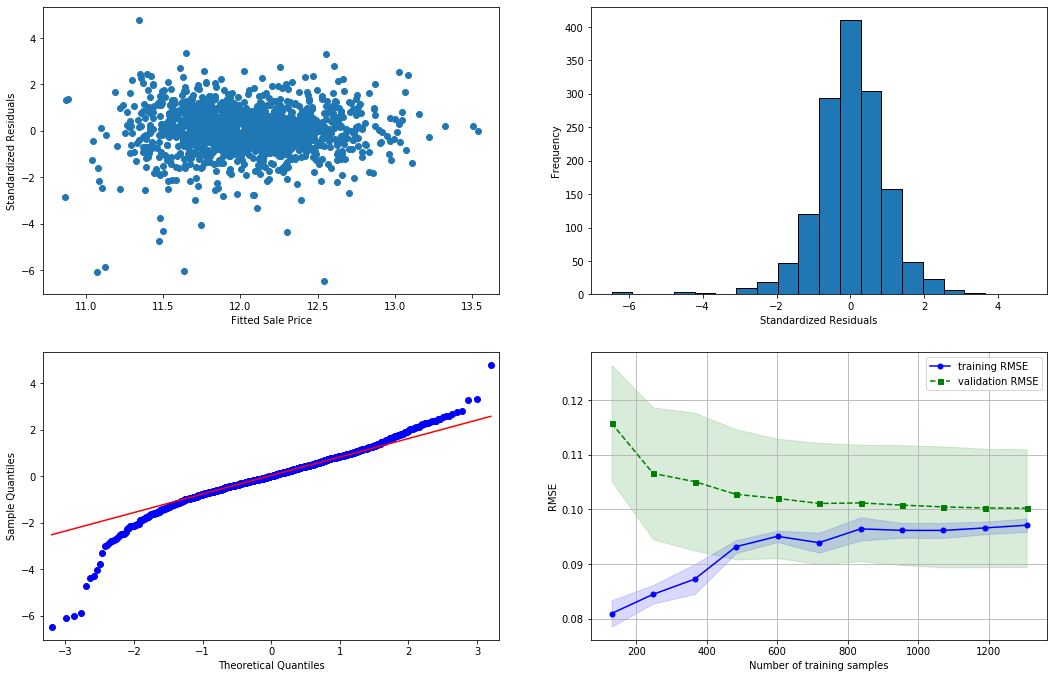

In [2]:
# Read in data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

# Parsimonious features (sfs)
sfs_log_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'Alley', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'HouseStyle_2.5Fin', 'Street_Pave', 'MSZoning_RM', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Foundation_PConc', 'Foundation_Wood', 'Heating_Wall', 'CentralAir_Y', 'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Normal', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MoSold_5']

# Make copy of dfs
train_df_sfs = train_df[sfs_log_features].copy()
test_df_sfs = test_df[sfs_log_features].copy()
train_label = train_labels.copy()

# Drop high VIF
train_df_sfs.drop(columns='GarageYrBlt', inplace=True)
test_df_sfs.drop(columns='GarageYrBlt', inplace=True)

# Impute LotFrontage
imputer = SimpleImputer(strategy='median')
train_df_sfs['LotFrontage'] = imputer.fit_transform(train_df_sfs['LotFrontage'].values.reshape(-1,1))
test_df_sfs['LotFrontage'] = imputer.transform(test_df_sfs['LotFrontage'].values.reshape(-1,1))

# Feature engineering
train_df_sfs['log_LotArea'] = np.log(train_df_sfs['LotArea'].values)
test_df_sfs['log_LotArea'] = np.log(test_df_sfs['LotArea'].values)
train_df_sfs.drop(columns='LotArea', inplace=True)
test_df_sfs.drop(columns='LotArea', inplace=True)

# Drop influential points
influential_points = [1298, 523, 30, 632, 812, 495]
train_df_sfs.drop(influential_points, inplace=True)
train_label.drop(influential_points, inplace=True)

# Scale numerical features
scaler = StandardScaler()
cat_feats = list(train_df_sfs.select_dtypes(include='uint8').columns)
num_feats = list(train_df_sfs.select_dtypes(exclude='uint8').columns)
train_df_sfs_scaled = scaler.fit_transform(train_df_sfs[num_feats])
test_df_sfs_scaled = scaler.transform(test_df_sfs[num_feats])
train_df_sfs = np.column_stack((train_df_sfs_scaled, train_df_sfs[cat_feats].values))
test_df_sfs = np.column_stack((test_df_sfs_scaled, test_df_sfs[cat_feats].values))
train_df_sfs = pd.DataFrame(train_df_sfs, columns = num_feats+cat_feats)
test_df_sfs = pd.DataFrame(test_df_sfs, columns = num_feats+cat_feats)
del(train_df_sfs_scaled)
del(test_df_sfs_scaled)

# Create arrays
X_train = train_df_sfs.values
X_test = test_df_sfs.values
y_train = np.log(train_label['SalePrice'].values)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit model
lin_regr = sm.OLS(y_train, X_train).fit()

########### Plots ###########

lin_regr_sk = LinearRegression()
lin_regr_sk.fit(train_df_sfs.values, y_train)

print(np.sqrt(mean_squared_error(train_label['SalePrice'].values, np.exp(lin_regr.predict()))))

fig=plt.figure(figsize=(18,18))

ax1 = plt.subplot(321)
ax1.scatter(lin_regr.predict(), lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(322)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(323)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(324)
lc_params = compute_learning_curve(estimator=lin_regr_sk, 
                                   X=train_df_sfs.values, 
                                   y=y_train,
                                   cv=10)
plot_learning_curve(ax4, lc_params)

<br>
<br>

## Feature importance

After standardizing the numerical features, the relative feature importance can be determined by comparing the magnitude of the coefficients that results from fitting a Linear Regression model to the standardized dataset.

In [244]:
coef_dict = {}
coef_dict['intercept'] = lin_regr.params[0]

for idx, coef in enumerate(lin_regr.params[1:]):
    coef_dict[list(train_df_sfs.columns)[idx]] = coef
coef_series = pd.Series(coef_dict)
del(coef_dict)
(coef_series[num_feats]).sort_values(ascending=False).head(30)

GrLivArea       0.134457
OverallQual     0.074853
YearBuilt       0.063554
OverallCond     0.043431
TotalBsmtSF     0.039323
log_LotArea     0.033493
BsmtFinSF1      0.033150
GarageCars      0.020761
BsmtFullBath    0.013931
FireplaceQu     0.013817
BsmtExposure    0.013594
HeatingQC       0.012769
YearRemodAdd    0.012286
HalfBath        0.011768
ScreenPorch     0.011610
WoodDeckSF      0.011472
FullBath        0.011447
KitchenQual     0.010597
GarageQual      0.010564
GarageArea      0.008323
LotFrontage     0.007359
Alley           0.006929
KitchenAbvGr   -0.012877
Functional     -0.022850
dtype: float64

**Observations**

When using the standardized regression coefficients to compare the features: 

- GrLivArea seems to be the most important numerical feature by an order of magnitude
- The rest of the numerical features are on roughly the same order of magnitude
- Ultimately how much these coefficients matter depends on the distribution of the feature (i.e. how much each feature varies from home to home)
- An effects plot will allow us to better observe this

<br>
<br>

## Effect Plots

From the [Interpretable ML book](https://christophm.github.io/interpretable-ml-book/limo.html):

> "The weights of the linear regression model can be more meaningfully analyzed when they are multiplied by the actual feature values. The weights depend on the scale of the features and will be different if you have a feature that measures e.g. a person’s height and you switch from meter to centimeter. The weight will change, but the actual effects in your data will not. It is also important to know the distribution of your feature in the data, because if you have a very low variance, it means that almost all instances have similar contribution from this feature. The effect plot can help you understand how much the combination of weight and feature contributes to the predictions in your data."

Because we have standardized the data, the coefficients won't depend on the scale of the features but will still depend on the distribution of the features. For example, features that are present and have the same value for all houses won't produce a difference in the final SalePrice, whereas features that vary a lot will affect the final SalePrice.

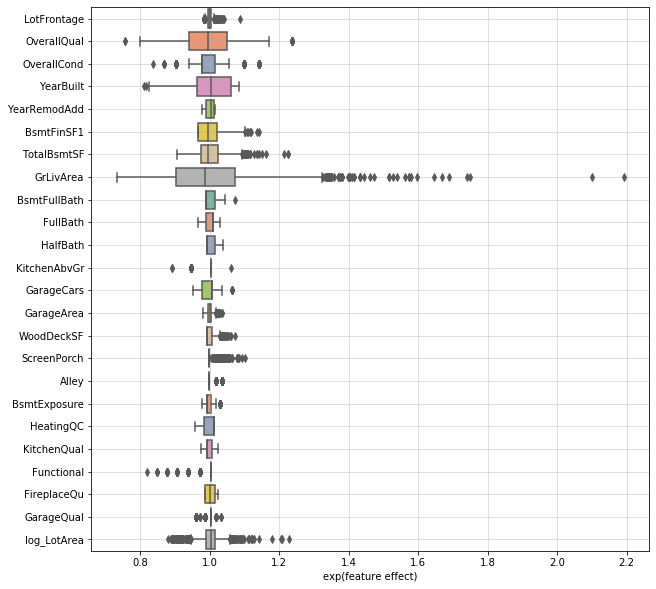

In [245]:
train_df_sfs_copy = train_df_sfs.copy()

# Add intercept feature
train_df_sfs_copy.insert(loc=0, column='Intercept', value = np.ones(1454))

# Create DataFrame of effects (mean centred)
effects_df = pd.DataFrame()
for coef, col in zip(lin_regr.params, train_df_sfs_copy.columns):
    effects_df[col] = np.exp(train_df_sfs_copy[col].values * coef)
        
plt.figure(figsize=(10,10))
sns.boxplot(data=effects_df[num_feats], orient='h', palette='Set2')
plt.grid(alpha=0.5)
plt.xlabel("exp(feature effect)");

**Oberservations**

- This plot shows boxplots of the feature effects for all numerical features over all of the training observations.

- The feature effect of feature $j$ for a particular observation $i$ is computed as:

$$\exp \left( \beta_k x_j^i \right)$$

- Since we are fitting the linear model to the Log response, our features effects have a multiplicative relationship with the reponse. This follows from the fact that:

$$
\begin{align}
\log{Y} & = \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p \\
Y & = \exp \left( \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p \right) \\
&= \exp \left( \beta_0 \right) \exp \left( \beta_1 x_1 \right) \ldots \exp \left( \beta_p x_p \right)
\end{align}
$$
- Thus the predicted sale price is the product of all of the feature effects (including the categorical feature effects that aren't shown in the plot above).
- GrLivArea varies the most and thus, in accordance with out feature importance computations, appears to be the most important and varying feature when determining the SalePrice of homes. 
- This is followed by OverallQual and YearBuilt, the latter of which is a heavily left-skewed feature
- In the derivation above, the linear portion of the model $\beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p$ should actually be approximately linked to the **median** Log response $\text{Median} \left( \log{Y}\right) $. More on this in the [section](#Interpreting-the-effect-of-feature-changes-on-a-Log-transformed-response) below

<br>
<br>

In [79]:
def house_value(feat_to_check='YearBuilt', feat_range = [0.25,0.75], median=True):
    if type(feat_to_check)==str:
        lb = feat_range[0]
        ub = feat_range[1]
        other_feats = list(effects_df.columns)
        other_feats.remove(feat_to_check)
        lb_sale_price = effects_df[other_feats].median().prod()*effects_df[feat_to_check].quantile(lb)
        ub_sale_price = effects_df[other_feats].median().prod()*effects_df[feat_to_check].quantile(ub)
        print("{} %ile for {}: {}".format(int(lb*100), feat_to_check, 
                                          scaler.inverse_transform(train_df_sfs[num_feats].quantile(lb))[num_feats.index(feat_to_check)]))
        print("{} %ile for {}: {}".format(int(ub*100), feat_to_check, 
                                          scaler.inverse_transform(train_df_sfs[num_feats].quantile(ub))[num_feats.index(feat_to_check)]))
        
        print("\nFor a house with all features at their median values:\n")
        print("Median sale price with '{}' at {} %ile: ${}".format(feat_to_check,
                                                                   int(lb*100),
                                                                   np.round(lb_sale_price, 2)
                                                                  ))
        print("Median sale price with '{}' at {} %ile: ${}".format(feat_to_check,
                                                                   int(ub*100),
                                                                   np.round(ub_sale_price, 2)
                                                                   ))
    elif type(feat_to_check)==list:
        lb = feat_range[0]
        ub = feat_range[1]
        other_feats = list(effects_df.columns)
        
        for feat in feat_to_check:
            other_feats.remove(feat)
            print("{} %ile for {}: {}".format(int(lb*100), feat, 
                                              scaler.inverse_transform(train_df_sfs[num_feats].quantile(lb))[num_feats.index(feat)]))
            print("{} %ile for {}: {}".format(int(ub*100), feat, 
                                              scaler.inverse_transform(train_df_sfs[num_feats].quantile(ub))[num_feats.index(feat)]))
            
        lb_sale_price = effects_df[other_feats].median().prod()
        ub_sale_price = effects_df[other_feats].median().prod()
        
        for feat in feat_to_check:
            lb_sale_price *= effects_df[feat].quantile(lb)
            ub_sale_price *= effects_df[feat].quantile(ub)

        print("\nFor a house with all features at their median values:\n")
        print('Median sale price with {} at {} %ile: ${}'.format(', '.join(feat_to_check),
                                                                 int(lb*100),
                                                                 np.round(lb_sale_price, 2)
                                                                ))
        print('Median sale price with {} at {} %ile: ${}'.format(', '.join(feat_to_check),
                                                                 int(ub*100),
                                                                 np.round(ub_sale_price, 2)
                                                                ))

In [80]:
house_value(feat_to_check='GrLivArea', feat_range=[0.5,0.9])

50 %ile for GrLivArea: 1465.0
90 %ile for GrLivArea: 2156.7

For a house with all features at their median values:

Median sale price with 'GrLivArea' at 50 %ile: $155939.18
Median sale price with 'GrLivArea' at 90 %ile: $187282.31


In [81]:
house_value(feat_to_check='TotalBsmtSF', feat_range=[0.5,0.9])

50 %ile for TotalBsmtSF: 991.5
90 %ile for TotalBsmtSF: 1601.4

For a house with all features at their median values:

Median sale price with 'TotalBsmtSF' at 50 %ile: $155939.18
Median sale price with 'TotalBsmtSF' at 90 %ile: $165219.3


In [82]:
house_value(feat_to_check=['GrLivArea', 'OverallQual', 'GarageCars'], feat_range=[0.5,0.9])

50 %ile for GrLivArea: 1465.0
90 %ile for GrLivArea: 2156.7
50 %ile for OverallQual: 6.0
90 %ile for OverallQual: 8.0
50 %ile for GarageCars: 2.0
90 %ile for GarageCars: 3.0

For a house with all features at their median values:

Median sale price with GrLivArea, OverallQual, GarageCars at 50 %ile: $155939.18
Median sale price with GrLivArea, OverallQual, GarageCars at 90 %ile: $214715.2


<br>
<br>

## Interpreting the effect of feature changes on a Log transformed response

When fitting an OLSR model to a log transformed response, the linear portion of the model $\beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p$ is approximately "linked" to the **median** log response when the residuals are approximately normal (where $\text{median} = \text{mean}$ for symmetric distributions).

The word linked is used here in the same manner as it is used in the context of **Generalized Linear Models** (GLMs) where the "Link function" specifies the relationship between the linear portion of the model and the **mean** response and where the GLM is fit to the **mean** of the response.

Since we are fitting an OLSR directly to the log response values themselves, we can use the approximation of symmetric residuals to interpret the coefficients, as they pertain to the median response, by making use of the following derivation courtesy of [STAT501 from psu.edu:](https://newonlinecourses.science.psu.edu/stat501/lesson/9/9.2)

<img src="images/log_response.png" width=600>

Where according to the notes:

>The median of the response changes by a factor of $e^{\beta_1}$ for each one unit increase in the predictor $x_1$.

This can be clearly seen by the final line of the derivation. The same derivation does not apply to the **mean** response due to the fact that

$$
\begin{align}
\log{Y} & = \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p + \epsilon \\
E \left[ \log{Y} \right] & = \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p \\
exp \left( E \left[ \log{Y} \right] \right) & = exp \left( \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p \right) \neq E \left[ Y|X \right] \\
\end{align}
$$

One way the median interpretation is useful is when investigating the effect that changing a feature value has on the (non-transformed) response

**Example: How does a 1 unit increase in feature value affect the response**

In [83]:
ci_dict = {}
ci_dict['intercept'] = lin_regr.conf_int()[0]

for idx, ci in enumerate(lin_regr.conf_int()[1:]):
    ci_dict[list(train_df_sfs.columns)[idx]] = ci
ci_series = pd.Series(ci_dict)
del(ci_dict)

In [240]:
std = scaler.inverse_transform(train_df_sfs[num_feats])[:,num_feats.index('GrLivArea')].std(ddof=1)
print("we can be 95% confident that the median predicted sale price will increase by a factor between\
 {:.1f}% and {:.1f}% for each {:.0f} SqFt increase in above ground living area".format((np.exp(ci_series['GrLivArea'])[0]-1)*100,
                                                                           (np.exp(ci_series['GrLivArea'])[1]-1)*100,
                                                                           std
                                                                          ))

we can be 95% confident that the median predicted sale price will increase by a factor between 13.1% and 15.7% for each 508 SqFt increase in above ground living area


Each unit increase is measured in units of standard deviation of the corresponding feature due to the fact that the data was scaled before the model was fit. Performing the appropriate math results in the following alternate interpretation:

In [238]:
std = scaler.inverse_transform(train_df_sfs[num_feats])[:,num_feats.index('GrLivArea')].std(ddof=1)
print("we can be 95% confident that the median predicted sale price will increase by a factor between\
 {:.1f}% and {:.1f}% for each {} SqFt increase in above ground living area".format((np.exp((ci_series['GrLivArea'][0]/std)*100)-1)*100,
                                                                                   (np.exp((ci_series['GrLivArea'][1]/std)*100)-1)*100,
                                                                                   100
                                                                                  ))

we can be 95% confident that the median predicted sale price will increase by a factor between 2.4% and 2.9% for each 100 SqFt increase in above ground living area


<br>
<br>

## Prediction intervals

What does the prediction interval look like for two homes, one of which has median feature values whilst the other has median feature values with an extra 1 unit ($\approx$ 508 SqFt) of GrLivArea

In [246]:
obs1 = train_df_sfs.median().values
obs2 = train_df_sfs.median().values
obs2[num_feats.index('GrLivArea')] = obs2[num_feats.index('GrLivArea')] + 1

obs1 = obs1.reshape(1,-1)
obs2 = obs2.reshape(1,-1)

obs1 = sm.add_constant(obs1, has_constant='add')
obs2 = sm.add_constant(obs2, has_constant='add')

obs1 = lin_regr.get_prediction(obs1).summary_frame()
obs2 = lin_regr.get_prediction(obs2).summary_frame()

print("For a house with median feature values:")
print("We can be 95% confident that the actual sale price will be between ${:.2f} and ${:.2f}".format(np.exp(obs1.obs_ci_lower.values)[0],
                                                                                       np.exp(obs1.obs_ci_upper.values)[0]
                                                                                      ))

print("\nFor a house with median feature values and an extra 508 SqFt of GrLivArea:")
print("We can be 95% confident that the actual sale price will be between ${:.2f} and ${:.2f}".format(np.exp(obs2.obs_ci_lower.values)[0],
                                                                                       np.exp(obs2.obs_ci_upper.values)[0]
                                                                                      ))

For a house with median feature values:
We can be 95% confident that the actual sale price will be between $128266.00 and $189582.78

For a house with median feature values and an extra 508 SqFt of GrLivArea:
We can be 95% confident that the actual sale price will be between $146698.71 and $216906.26


Note that GrLivArea is moderately correlated with other features (such as OverallQual and GarageCars) and thus a house with more GrLivArea will likely actually result in a higher sale price than indicated in the prediction intervals above.

<br>
<br>

# Regression Workflow

Before EDA

- Fill in missing data:
    - see [types of missing data](https://www.displayr.com/different-types-of-missing-data/)
    - Handle MNAR entries (fill in with appropriate value e.g. None or 0)
    - Impute MAR entries (central tendency, MICE, KNN etc) See [fancyimpute](https://github.com/iskandr/fancyimpute)
- Transform Categorical variables
    - Ordinal mappings for ordinal categorical variables or Dummy encoding for nominal categorical variables
    - For high cardinality categorical variables see [categorical encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
    
EDA

- Check response:
    - Is it normally distributed? bounded below? skewed?
    - A transformation might help the problems above
    - A GLM might be appropriate for bounded and skewed responses
- Check numerical variables
    - Correlation heatmap
    - Scatterplot matrix for highly correlated (with response) features
    - etc
- Check categorical variables
    - Ordered Boxplots
    - Barcharts
    - etc

First model

- Check and assess [model assumptions](https://newonlinecourses.science.psu.edu/stat501/node/317/)
- Determine next steps from the initial model
    - if features need to be pruned, perform feature selection
    - if non-linearity exists, explore hard fitting models
    - if heteroscedasticity is present, explore response and/or feature transformations or GLMs
    - if autocorrelation exists, explore time-series methods

Subsequent models

- Check for influential points
- Perform feature engineering (interactions + non-linear features) using the reduced set of features
- After identifying useful features using feature selection:
    - Produce residual plot against remaining (or engineered) predictors to identify any potential useful predictors to be added
- Try ML models with high predictive power:
    - GLM/GAM
    - Random Forest
    - GBDT
    - XGBoost, LightGBM, Catboost
- Run more sophisticated models to check the performance deficit between interpretable models and hard-fitting models
    
Conclusion

- Evaluate interpretable models (OLSR, GLM) by [visualizing the coefficients](https://christophm.github.io/interpretable-ml-book/limo.html)
- Perform inference on interpretable models:
    - Check p-values of coefficients
    - Perform sequential sum of squares F-test on nested models where applicable (e.g. on dropped high p-value features)
    - Feature importance can be compared using standardized coefficients
- Identify important features and produce useful predictions
    - For features with high coefficient values, interpret the coefficients
    - Check prediciton intervals for practically (and statistically) significant changes to the response when varying a certain important features
- Evaluate uninterpretable models using [model-agnostic interpretation methods](https://christophm.github.io/interpretable-ml-book/agnostic.html)